In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [2]:
# Load dataset
df = pd.read_csv('/Users/pyaekyitharchaw/Documents/CSCT Project/Data/botswana_bank_customer_churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,First Name,Date of Birth,Gender,Marital Status,Number of Dependents,Occupation,Income,...,Preferred Communication Channel,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Churn Reason,Churn Date,Balance,NumOfProducts,NumComplaints
0,1,83ef0b54-35f6-4f84-af58-5653ac0c0dc4,Smith,Troy,1987-08-29,Male,Divorced,3,Information systems manager,77710.14,...,Phone,397,24,41959.74,0,NaN,NaN,211359.05,1,0
1,2,009f115a-e5ca-4cf4-97d6-530140545e4e,Sullivan,Katrina,2000-02-07,Female,Married,1,Charity fundraiser,58209.87,...,Email,665,10,8916.67,0,NaN,NaN,30624.76,4,1
2,3,66309fd3-5009-44d3-a3f7-1657c869d573,Fuller,Henry,1954-02-03,Female,Single,1,Television production assistant,9794.01,...,Email,715,21,43270.54,0,NaN,NaN,111956.61,2,6
3,4,b02a30df-1a5f-4087-8075-2a35432da641,Young,Antonio,1991-01-15,Female,Divorced,5,Agricultural engineer,15088.98,...,Phone,747,17,17887.65,0,NaN,NaN,201187.61,1,0
4,5,0d932e5b-bb3a-4104-8c83-f84270f7f2ea,Andersen,John,1992-04-08,Female,Divorced,2,"Teacher, early years/pre",60726.56,...,Email,549,25,32686.84,0,NaN,NaN,60391.24,5,6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115640 entries, 0 to 115639
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   RowNumber                        115640 non-null  int64  
 1   CustomerId                       115640 non-null  object 
 2   Surname                          115640 non-null  object 
 3   First Name                       115640 non-null  object 
 4   Date of Birth                    115640 non-null  object 
 5   Gender                           115640 non-null  object 
 6   Marital Status                   115640 non-null  object 
 7   Number of Dependents             115640 non-null  int64  
 8   Occupation                       115640 non-null  object 
 9   Income                           115640 non-null  float64
 10  Education Level                  115640 non-null  object 
 11  Address                          115640 non-null  object 
 12  Co

In [5]:
df.isnull().sum()

RowNumber                               0
CustomerId                              0
Surname                                 0
First Name                              0
Date of Birth                           0
Gender                                  0
Marital Status                          0
Number of Dependents                    0
Occupation                              0
Income                                  0
Education Level                         0
Address                                 0
Contact Information                     0
Customer Tenure                         0
Customer Segment                        0
Preferred Communication Channel         0
Credit Score                            0
Credit History Length                   0
Outstanding Loans                       0
Churn Flag                              0
Churn Reason                       101546
Churn Date                         101546
Balance                                 0
NumOfProducts                     

In [6]:
duplicated_df = df[df.duplicated(subset='CustomerId')]
duplicated_df.head()

,RowNumber,CustomerId,Surname,First Name,Date of Birth,Gender,Marital Status,Number of Dependents,Occupation,Income,...,Preferred Communication Channel,Credit Score,Credit History Length,Outstanding Loans,Churn Flag,Churn Reason,Churn Date,Balance,NumOfProducts,NumComplaints


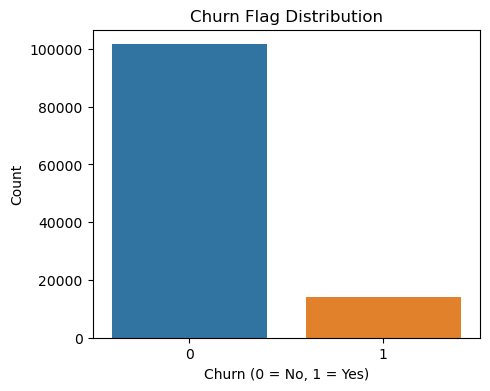

In [7]:
plt.figure(figsize=(5, 4))
sns.countplot(x='Churn Flag', data=df)
plt.title('Churn Flag Distribution')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

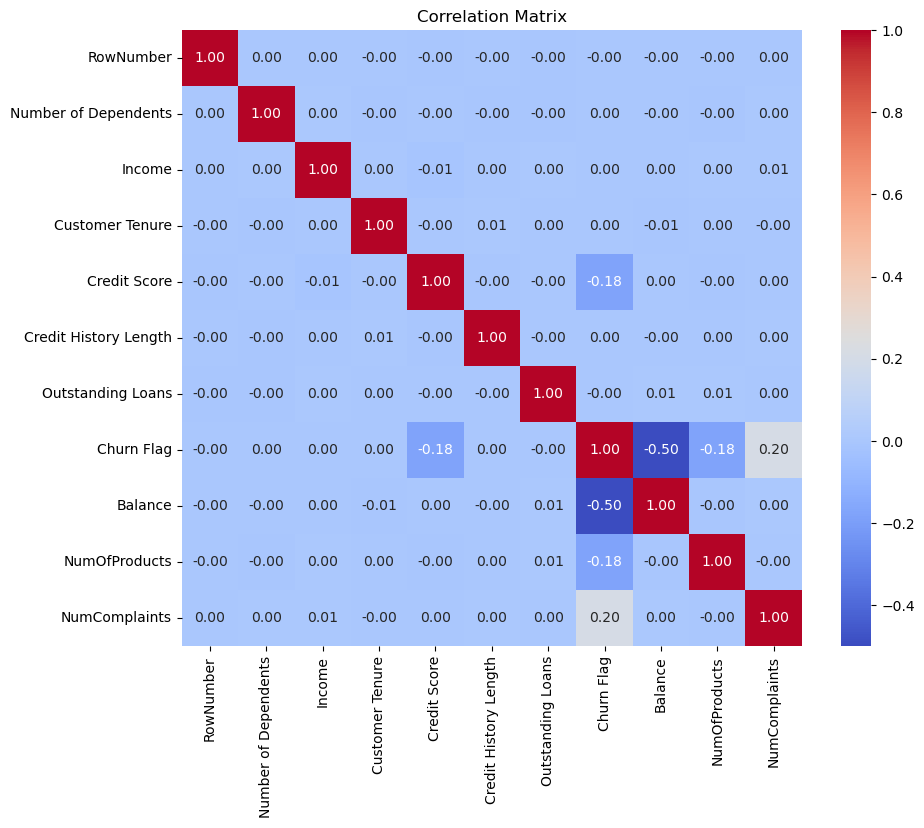

In [8]:
num_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['customer_id'], errors='ignore').columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

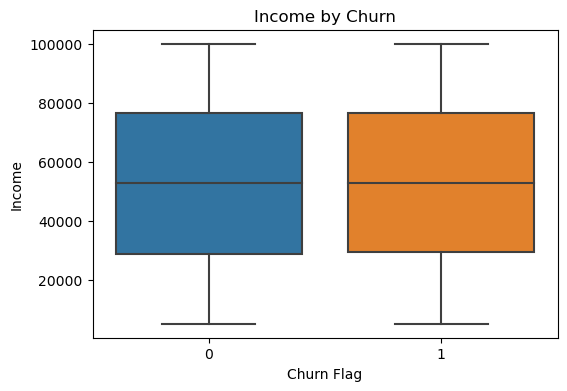

In [9]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Churn Flag', y='Income', data=df)
plt.title('Income by Churn')
plt.show()

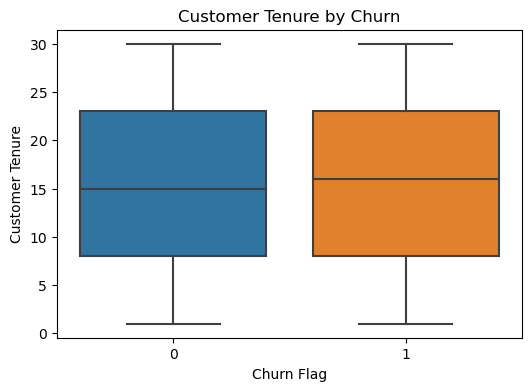

In [10]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Churn Flag', y='Customer Tenure', data=df)
plt.title('Customer Tenure by Churn')
plt.show()

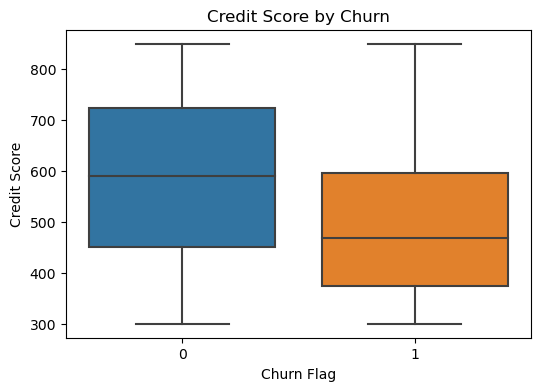

In [11]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Churn Flag', y='Credit Score', data=df)
plt.title('Credit Score by Churn')
plt.show()

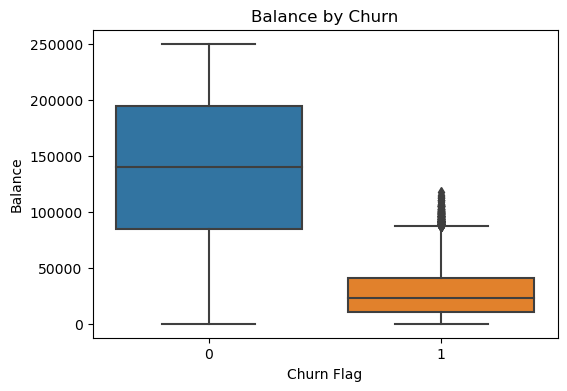

In [12]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Churn Flag', y='Balance', data=df)
plt.title('Balance by Churn')
plt.show()

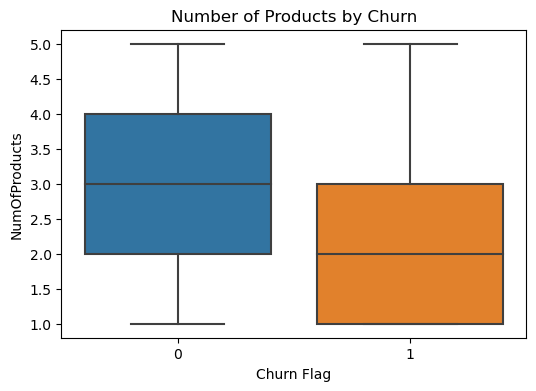

In [13]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Churn Flag', y='NumOfProducts', data=df)
plt.title('Number of Products by Churn')
plt.show()

In [14]:
# Define bin labels
bin_labels = ['Low', 'Medium', 'High']

# Binning 
df['Income Band'], income_bins = pd.qcut(df['Income'], q=3, labels=bin_labels, retbins=True, duplicates='drop')
df['Balance Band'], balance_bins = pd.qcut(df['Balance'], q=3, labels=bin_labels, retbins=True, duplicates='drop')
df['Outstanding Loans Band'], outstanding_bins = pd.qcut(df['Outstanding Loans'], q=3, labels=bin_labels, retbins=True, duplicates='drop')

# Encoding for labeled bins
ordinal_map = {'Low': 0, 'Medium': 1, 'High': 2}
df['Income Band Encoded'] = df['Income Band'].map(ordinal_map)
df['Balance Band Encoded'] = df['Balance Band'].map(ordinal_map)
df['Outstanding Loans Band Encoded'] = df['Outstanding Loans Band'].map(ordinal_map)

# Save bin edges for prediction use
joblib.dump(income_bins, 'income_bins.pkl')
joblib.dump(balance_bins, 'balance_bins.pkl')
joblib.dump(outstanding_bins, 'outstanding_bins.pkl')

# Save mapping dictionaries
joblib.dump(ordinal_map, 'income_map.pkl')
joblib.dump(ordinal_map, 'balance_map.pkl')
joblib.dump(ordinal_map, 'outstanding_map.pkl')


['outstanding_map.pkl']

In [15]:
X = df[['Credit Score', 'Customer Tenure', 'Balance Band Encoded',
        'NumOfProducts', 'Outstanding Loans Band Encoded', 'Income Band Encoded',
        'Credit History Length', 'NumComplaints']]
y = df['Churn Flag']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [16]:
models = {
    'XGBoost': XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'LGBM': LGBMClassifier(max_depth=5, num_leaves=20, class_weight='balanced', objective='binary', random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n Model: {name}")
    y_pred = cross_val_predict(model, X_scaled, y, cv=cv)
    y_proba = cross_val_predict(model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]

    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    print("ROC AUC Score:")
    print(f"{roc_auc_score(y, y_proba):.4f}")



 Model: XGBoost


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:46:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:46:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:46:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters:

Confusion Matrix:
[[90296 11250]
 [  717 13377]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    101546
           1       0.54      0.95      0.69     14094

    accuracy                           0.90    115640
   macro avg       0.77      0.92      0.81    115640
weighted avg       0.94      0.90      0.91    115640

ROC AUC Score:
0.9692

 Model: Logistic Regression
Confusion Matrix:
[[90863 10683]
 [  684 13410]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    101546
           1       0.56      0.95      0.70     14094

    accuracy                           0.90    115640
   macro avg       0.77      0.92      0.82    115640
weighted avg       0.94      0.90      0.91    115640

ROC AUC Score:
0.9721

 Model: Random Forest
Confusion Matrix:
[[98406  3140]
 [ 5169  8925]]

Classification Report:
              precision    reca

/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11275, number of negative: 81237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 92512, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11275, number of negative: 81237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 92512, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11275, number of negative: 81237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 92512, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11275, number of negative: 81237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 92512, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11276, number of negative: 81236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 92512, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11275, number of negative: 81237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 92512, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11275, number of negative: 81237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 92512, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11275, number of negative: 81237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 92512, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 11275, number of negative: 81237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 92512, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Confusion Matrix:
[[89573 11973]
 [  452 13642]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.94    101546
           1       0.53      0.97      0.69     14094

    accuracy                           0.89    115640
   macro avg       0.76      0.93      0.81    115640
weighted avg       0.94      0.89      0.90    115640

ROC AUC Score:
0.9717


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [17]:

final_model = XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss', random_state=42)
final_model.fit(X_scaled, y)
joblib.dump(final_model, 'model.pkl')
print("✅ Final model saved.")


✅ Final model saved.


/Users/pyaekyitharchaw/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
